# Discretising infinite integrals

For the multilayer finite dipole method (FDM), we need to calculate the electric potential and field at the surface using integrals of the form
$$
\int_0^\infty\beta(k)f(k)dk
$$
where $f(k)$ is a weighting function
$$
f(k)=\begin{equation*}
\left\{ 
  \begin{aligned}
    f_{\phi}(k)=e^{-2k}, & \text{ for potential},\\
    f_E(k)=-k e^{-2k}, & \text{ for electric field}.
  \end{aligned}
  \right.
\end{equation*}
$$

`scipy.integrate.quad_vec` can perform infinite integrals, but it relies on adaptive quadrature and it can't be compiled using `numba`.

In [1]:
import numpy as np
from scipy.integrate import quad_vec, trapezoid, simpson
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from tqdm.notebook import tqdm

## Truncating the integral
It would be faster if we could truncate the infinite integral then perform fixed quadrature taking advantage of `numpy`/`numba`'s fast vectorised array routines.

We don't always know the form of $\beta(k)$, but we can assume that when the weighting function $f(x)$ converges then the whole integrand must also converge (unless $\beta(k)>>f(k)$, which seems unlikely).
For this reason we can restrict our study to the simpler integral
$$
\int_0^\infty f(k)dk
$$
which has a known solution for both electric potential and field.

We can quantify the proportion of the total integral unaccounted for for a particular truncation as
$$
1 - \frac{\int_0^{k_{max}}f(k)dk}{\int_0^\infty f(k)dk} = \begin{equation*}
\left\{ 
  \begin{aligned}
    \Delta_{\phi} = e^{-2k_{max}}, & \text{ for potential},\\
    \Delta_{E} = (2k_{max}+1)e^{-2k_{max}}, & \text{ for electric field},
  \end{aligned}
  \right.
\end{equation*}
$$
where $k_{max}$ is the value of $k$ at which to truncate the integral.
This can be used to approximate the relative error of the full integral.
(Note that for all $k_{max}>0$, $\Delta_{E}>\Delta_{\phi}$).

The interactive graph below ranks the errors introduced by truncating the integrals.

In [4]:
def f_phi(k):
    return np.exp(-2 * k)


def f_E(k):
    return -k * np.exp(-2 * k)


k_lims = -80, 100

k_line = np.linspace(*k_lims, 512)
phi_line = f_phi(k_line)
E_line = f_E(k_line)

phi_soln = 0.5
E_soln = -0.25

methods = (
    "algebraic",
    "adaptive",
    "trapezoid",
    "simpson",
)
SM = plt.cm.ScalarMappable(
    cmap=plt.cm.coolwarm_r, norm=Normalize(vmin=0, vmax=len(methods) - 1)
)


@widgets.interact(N=(2, 1024, 2), k_max=(0.0, k_lims[1]))
def plot(N, k_max):
    k = np.linspace(0, k_max, N + 1)
    phi = f_phi(k)
    E = f_E(k)

    phi_errors = {
        "algebraic": np.exp(-2 * k_max),
        "adaptive": 1 - quad_vec(f_phi, 0, k_max)[0] / phi_soln,
        "trapezoid": 1 - trapezoid(phi, x=k) / phi_soln,
        "simpson": 1 - simpson(phi, x=k) / phi_soln,
    }
    phi_vals = np.sort(np.abs(list(phi_errors.values())))
    phi_rank = {
        method: len(methods) - 1 - np.searchsorted(phi_vals, np.abs(phi_errors[method]))
        for method in methods
    }

    E_errors = {
        "algebraic": (2 * k_max + 1) * np.exp(-2 * k_max),
        "adaptive": 1 - quad_vec(f_E, 0, k_max)[0] / E_soln,
        "trapezoid": 1 - trapezoid(E, x=k) / E_soln,
        "simpson": 1 - simpson(E, x=k) / E_soln,
    }
    E_vals = np.sort(np.abs(list(E_errors.values())))
    E_rank = {
        method: len(methods) - 1 - np.searchsorted(E_vals, np.abs(E_errors[method]))
        for method in methods
    }

    fig = plt.figure()
    gs = plt.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=(1, 0.05))
    phi_ax = fig.add_subplot(gs[0, 0])
    E_ax = fig.add_subplot(gs[1, 0])

    phi_ax.plot(k_line, phi_line)
    phi_ax.scatter(k, phi)

    E_ax.plot(k_line, E_line)
    E_ax.scatter(k, E)

    spans = [ax.axvspan(0, k_max, alpha=0.1) for ax in (phi_ax, E_ax)]
    for ax, errors, rank in zip(
        (phi_ax, E_ax), (phi_errors, E_errors), (phi_rank, E_rank)
    ):
        for method, y in zip(methods, np.linspace(0.9, 0.5, len(methods))):
            ax.text(
                0.05 * k_lims[0],
                y,
                f"{method}: {100 * errors[method]:.4g}%",
                ha="right",
                transform=ax.get_xaxis_transform(),
                c=SM.to_rgba(rank[method]),
            )

    phi_ax.set(xlim=k_lims, xticklabels=[], ylim=(-0.05, 1), ylabel=r"$f_{\phi}(k)$")
    E_ax.set(xlim=k_lims, ylim=(-0.25, 0.05), xlabel=r"$k$", ylabel=r"$f_E(k)$")

    cax = fig.add_subplot(gs[:, 1])
    cbar = fig.colorbar(SM, cax=cax, label="error rank")
    cbar.set_ticks((0, len(methods) - 1))
    cbar.set_ticklabels(("worst", "best"))

    fig.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=512, description='N', max=1024, min=2, step=2), FloatSlider(value=50.0, …

One issue with integrating both forms of $f(x)$ is that they are heavily weighted towards $k=0$.
That means that for fixed width quadrature methods, such as trapezium or Simpson's, the number of samples must be set high enough to capture the information close to zero in enough detail.
Increasing $k_{max}$, while keeping the number of samples $N$ constant can actually reduce the accuracy of the integral.
The images below show the relative errors introduced by the trapezium and Simpson's methods at various values of $k_{max}$ and $N$.

(Note, only odd numbers of samples are investigated, as Simpson's method requires an even number of intervals).

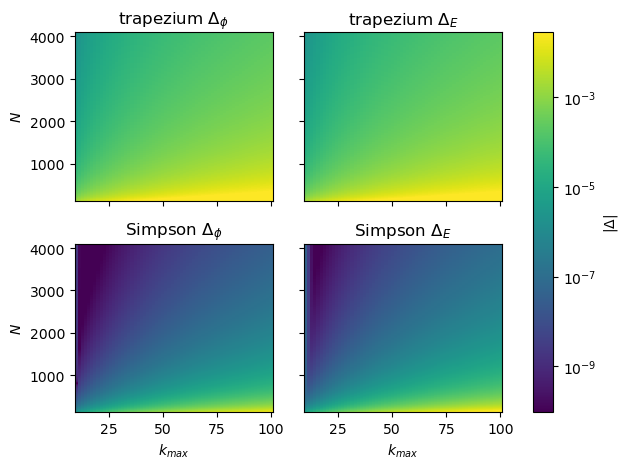

In [3]:
def f_phi(k):
    return np.exp(-2 * k)


def f_E(k):
    return -k * np.exp(-2 * k)


phi_soln = 0.5
E_soln = -0.25

k_max = np.linspace(10, 100, 64)
N = np.arange(128, 4097, 8)

k_max_2d, N_2d = np.meshgrid(k_max, N)

shape = k_max.size, N.size
trapz_error_phi = np.zeros(shape)
simps_error_phi = np.zeros(shape)
trapz_error_E = np.zeros(shape)
simps_error_E = np.zeros(shape)

for i, k_m in enumerate(k_max):
    for j, n in enumerate(N):
        k, dk = np.linspace(0, k_m, n + 1, retstep=True)
        phi = f_phi(k)
        E = f_E(k)

        trapz_error_phi[i, j] = 1 - trapezoid(phi, dx=dk) / phi_soln
        simps_error_phi[i, j] = 1 - simpson(phi, dx=dk) / phi_soln
        trapz_error_E[i, j] = 1 - trapezoid(E, dx=dk) / E_soln
        simps_error_E[i, j] = 1 - simpson(E, dx=dk) / E_soln

fig = plt.figure()
gs = plt.GridSpec(figure=fig, nrows=2, ncols=3, width_ratios=[1, 1, 0.1])
axes = np.array([[fig.add_subplot(gs[i, j]) for i in range(2)] for j in range(2)])

ims = trapz_error_phi, simps_error_phi, trapz_error_E, simps_error_E
titles = (
    "trapezium $\Delta_{\phi}$",
    "Simpson $\Delta_{\phi}$",
    "trapezium $\Delta_E$",
    "Simpson $\Delta_E$",
)
plot_lims = np.percentile(np.abs(ims), [1, 99])

for ax, im, title in zip(axes.flatten(), ims, titles):
    pcm = ax.pcolormesh(
        k_max_2d,
        N_2d,
        np.abs(im).T,
        shading="auto",
        norm=LogNorm(vmin=plot_lims[0], vmax=plot_lims[1]),
    )
    ax.set_title(title)

for ax in axes[0]:
    ax.set_ylabel("$N$")
for ax in axes[1]:
    ax.set_yticklabels([])
for ax in axes[:, 0]:
    ax.set_xticklabels([])
for ax in axes[:, 1]:
    ax.set_xlabel("$k_{max}$")

cax=fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(pcm, cax=cax, label=r"$\left|\Delta\right|$")

fig.tight_layout()
plt.show()


## Clenshaw-Curtis quadrature

Clenshaw-Curtis quadrature relies on converting a bounded definite integral between $1$ and $-1$ to a summation based on cosine series coefficients using the relation
$$
\int_{-1}^{1} f(x) dx
= \int_{0}^{\pi} f(cos(\theta)) sin(\theta) d\theta
= a_0 + \sum_{n=1}^{\infty} \frac{2 a_{2n}}{1 - (2 n)^2},
$$
where $a_n$ are the cosine series coefficients for $f(cos(\theta))$, defined by
$$
a_n = \frac{2}{\pi} \int_{0}^{\pi} f(cos(\theta)) cos(n \theta) d\theta.
$$

As $f(cos(\theta))$ is, periodic by definition, we can approximate the cosine series integral for a finite Nyquist frequency $N$ by the type-I discrete cosine transform (DCT), as
$$
a_{2 n} \approx\begin{equation*} 
    \frac{2}{N}\left[\\
        \frac{f(1) + f(-1)}{2}
        + f(0)(-1)^n
        + \sum_{n'=1}^{\frac{N}{2} - 1}\left(
            f\left(cos\left(\frac{n'\pi}{N}\right)\right)
            + f\left(-cos\left(\frac{n'\pi}{N}\right)\right)
        \right)\\
    \right]
\end{equation*}
$$